# Generate a uniform dataset given Lichess Data

## Pre-requisites
### If running on Google Collab
If not running on Google collab do not run these next two cells!

In [1]:
# Install the only dependency not available from collab directly
#!pip install chess

In [2]:
'''from google.colab import drive

drive.mount('/content/gdrive')
working_directory = '/content/gdrive/MyDrive/chessbot_weights/'
print(f'Saving to {working_directory}')
'''

### If not running on Google Collab
Set the weights directory variable to wherever you would like data saved.

In [1]:
!mkdir -p data
working_directory = './data'

## Lichess Data
### Get the Data
This compression format is really nice, so you can cancel this cell whenever you want and all the games that were downloaded will be maintained. In my experience 300Mb gets well over 100,000 games.

In [2]:
!wget https://database.lichess.org/standard/lichess_db_standard_rated_2022-01.pgn.zst

--2023-03-28 14:30:07--  https://database.lichess.org/standard/lichess_db_standard_rated_2023-02.pgn.zst
Resolving database.lichess.org (database.lichess.org)... 141.95.66.62, 2001:41d0:700:5e3e::
Connecting to database.lichess.org (database.lichess.org)|141.95.66.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31838284336 (30G) [application/octet-stream]
Saving to: ‘lichess_db_standard_rated_2023-02.pgn.zst’

rd_rated_2023-02.pg   1%[                    ] 306.52M  18.0MB/s    eta 29m 49s^C


### Decompress the Data

In [10]:
#!sudo apt install zstd
!pzstd -d lichess_db_standard_rated_2022-01.pgn.zst

[sudo] password for btf: 


## Draw a uniform distribution of game positions
Given the Lichess data, we want to draw a uniform distribution of labelled positions to later train models on.

In [4]:
import chess
import chess.pgn
import numpy as np
import matplotlib.pyplot as plt

In [17]:
from sklearn.utils import shuffle

def get_uniform_dataset_from_pgn_file(pgn_file, n_samples, n_bins, verbose=1):
    X = np.empty(n_samples, dtype=object)
    y = np.empty(n_samples)
    
    # Used to make sure the data in X and y is uniform (by stockfish label)
    bin_capacity = n_samples // n_bins
    bin_boundaries = np.linspace(0, 1.00001, n_bins + 1)
    bins = np.zeros(n_bins, dtype=int)
    
    with open(pgn_file) as pgn:
        i = 0
        while i < n_samples:
            game = chess.pgn.read_game(pgn)
            if game is None:
                raise Exception('DataGenerator: Out of data to read from disk.')

            # Only train on game played to completion, that were not draws, and that have evaluations
            next_node = game.next()
            if not (game.headers['Termination'] == 'Normal' and game.headers['Result'] in ['1-0', '0-1'] and next_node and next_node.eval() != None):
                continue

            # Generate the data from the game
            board = game.board()
            for node in game.mainline():
                board.push(node.move)

                try:
                    eval = node.eval().white().wdl().expectation()
                except:
                    # Sometimes only part of the game is labelled, so we skip the rest of this game
                    break

                # Don't keep this sample if we have already collected enough samples in its bin
                bin = np.digitize(eval, bin_boundaries) - 1
                if bins[bin] < bin_capacity:
                    X[i] = board.fen()
                    y[i] = eval
                    bins[bin] += 1
                    i += 1
                
                if verbose > 0:
                    print(f'\rGenerated {i}/{n_samples} samples...', end='')

    # Shuffle X and y so batches of data are a bit more normal
    X, y = shuffle(X, y)

    return X, y

In [15]:
#n_samples = 125000
n_samples = 1250
n_bins = 20

# Running this line takes roughly 5 times the amount of time it takes to generate half the samples
X, y = get_uniform_dataset_from_pgn_file('lichess_db_standard_rated_2022-01.pgn', n_samples, n_bins)

Generated 120/125 samples...

### Plot the distribution of the labels

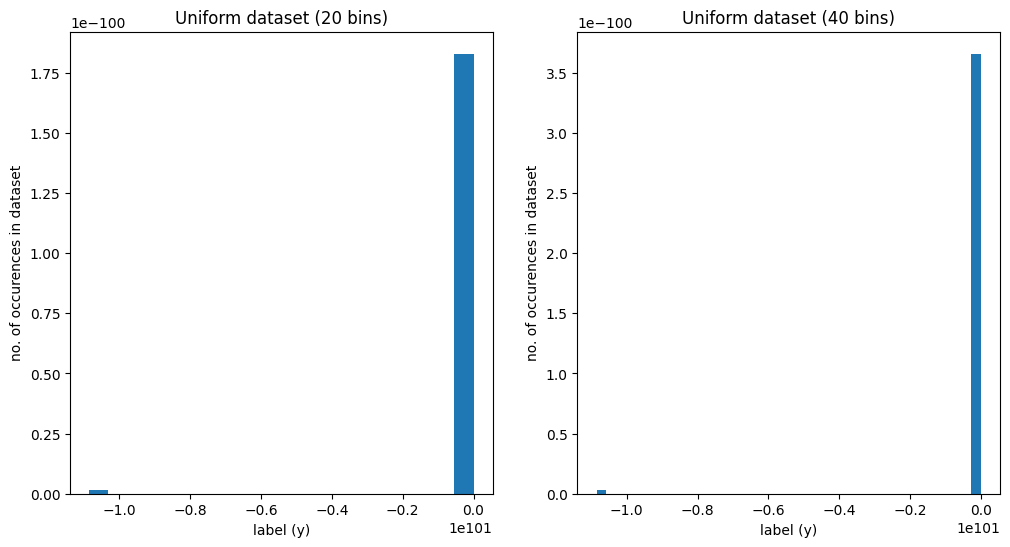

In [16]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
for i, ax in enumerate(axes):
    ax.hist(y, bins=n_bins*(i+1), density=True)
    ax.set_title(f'Uniform dataset ({n_bins*(i+1)} bins)')
    ax.set_xlabel('label (y)')
    ax.set_ylabel('no. of occurences in dataset')
plt.show()

### Save the labelled data to files
Given that the labelled data we just generated, split it into train, test, and validation sets and save those to files. This takes up about 0.25MB per 10,000 games.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

print(f'Training set: {len(X_train)} samples')
print(f'Validation set: {len(X_val)} samples')
print(f'Test set: {len(X_test)} samples')

np.savez_compressed(f'{working_directory}/training_set.npz', X=X_train, y=y_train)
np.savez_compressed(f'{working_directory}/validation_set.npz', X=X_val, y=y_val)
np.savez_compressed(f'{working_directory}/test_set.npz', X=X_test, y=y_test)

Training set: 100000 samples
Validation set: 12500 samples
Test set: 12500 samples
